In [24]:
using LinearAlgebra
using Plots
using Printf

In [5]:
# Pkg.update("Plots")

In [8]:
control_pts = [(0,0),(1,1),(2,3),(1,4),(0,4),(-1,3),(0,1),(1,0)]

8-element Vector{Tuple{Int64, Int64}}:
 (0, 0)
 (1, 1)
 (2, 3)
 (1, 4)
 (0, 4)
 (-1, 3)
 (0, 1)
 (1, 0)

In [34]:
struct Bezier
    points::Matrix{Float64}
    points_dx::Matrix{Float64}
    n::Int
end

function B(t, bc::Bezier)
    b = deepcopy(bc.points)
    for i=1:bc.n 
        for j=1:bc.n-i
            b[j,:] = (1-t)*b[j,:] + t*b[j+1,:]
        end
    end
    return b[1,:]
end

function dB(t, bc::Bezier)
    b = deepcopy(bc.points_dx)
    for i=1:(bc.n-1) 
        for j=1:(bc.n-1)-i
            b[j,:] = (1-t)*b[j,:] + t*b[j+1,:]
        end
    end
    return b[1,:]
end

function compute_pts(bc::Bezier, num=100)
    t = LinRange(0, 1, num)
    x = zeros((num, 2))
    for ti=1:num
        x[ti, :] = B(t[ti], bc) 
    end
    return x
end


compute_pts (generic function with 2 methods)

In [15]:
pts = [control_pts[i][j] for i=1:length(control_pts), j=1:2]

8×2 Matrix{Int64}:
  0  0
  1  1
  2  3
  1  4
  0  4
 -1  3
  0  1
  1  0

In [16]:
n = size(pts)[1] - 1
pts_dx = [n.*(pts[i+1, j]-pts[i, j]) for i=1:n, j=1:2]

7×2 Matrix{Int64}:
  7    7
  7   14
 -7    7
 -7    0
 -7   -7
  7  -14
  7   -7

In [17]:
bc = Bezier(pts, pts_dx, size(pts)[1])

Bezier([0.0 0.0; 1.0 1.0; … ; 0.0 1.0; 1.0 0.0], [7.0 7.0; 7.0 14.0; … ; 7.0 -14.0; 7.0 -7.0], 8)

In [40]:
# self intersection

function self_intersect(bc, iters=10)
    function f(t, s, b)
        x1, y1 = B(t, b)
        x2, y2 = B(s, b)
        return [x1 - x2, y1 - y2]
    end

    function Jf(t, s, b)
        x1, y1 = dB(t, b)
        x2, y2 = dB(s, b)
        return [x1 -x2; y1 -y2]
    end

    x = compute_pts(bc)
    plot(x[:, 1], x[:, 2])
    t0 = 0
    s0 = 1
    x1, y1 = B(t0, bc)
    x2, y2 = B(s0, bc)
    plot!([x1, x2], [y1, y2], marker=:circle)
    for i=1:iters
        t0, s0 = [t0, s0] - Jf(t0, s0, bc)\f(t0, s0, bc)
        x1, y1 = B(t0, bc)
        x2, y2 = B(s0, bc)
        plot!([x1, x2], [y1, y2], marker=:circle)
    end
    @printf("intersection points: t (x, y)\n %.10f:(%.10f, %.10f)\n %.10f:(%.10f, %.10f)", t0, x1, y1, s0, x2, y2)

    p = plot!(legend=false, axisratio=:equal)
    return [t0, s0, p]
end

self_intersect (generic function with 2 methods)

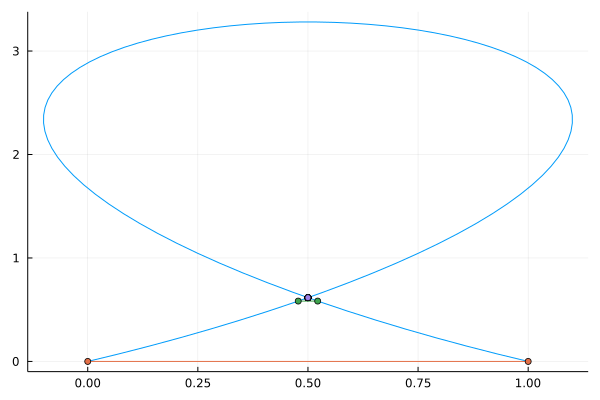

intersection points: t (x, y)
 0.0750643506:(0.5000000000, 0.6162957793)
 0.9249356494:(0.5000000000, 0.6162957793)

In [41]:
t, s, p = self_intersect(bc)
display(p)

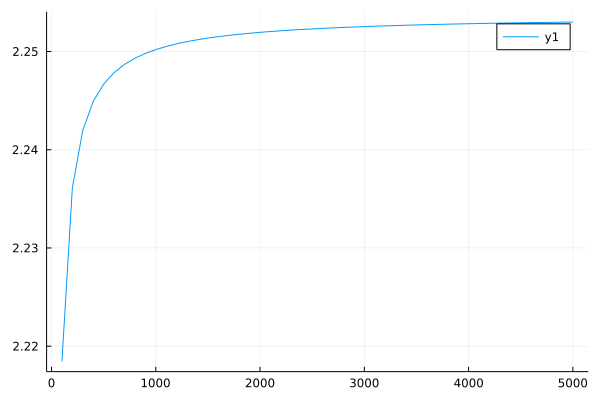

Area of the loop: 2.253007473698406

In [57]:
# integrate

# trapeziod

function integrate(t, s, bc)

    function f(t, b)
        x, y = B(t, b)
        return [-y, x]
    end

    Is = []
    st = 100:100:5000

    for j in st
        I = 0
        steps = j
        a = t0
        h = (s0-t0)/steps
        b = a + h
        for i=0:steps
            da = dot(f(a, bc), dB(a, bc))
            db = dot(f(b, bc), dB(b, bc))
            cI = h * ((da + db) / 2)
            I += cI
            a = b
            b += h 
        end
        I /= 2
        append!(Is, I)
    end
    p = plot(st, Is)
    @printf("Area of the loop: %.15f", last(Is))
    return [last(Is), p]
end

a, p = integrate(t, s, bc)
display(p)

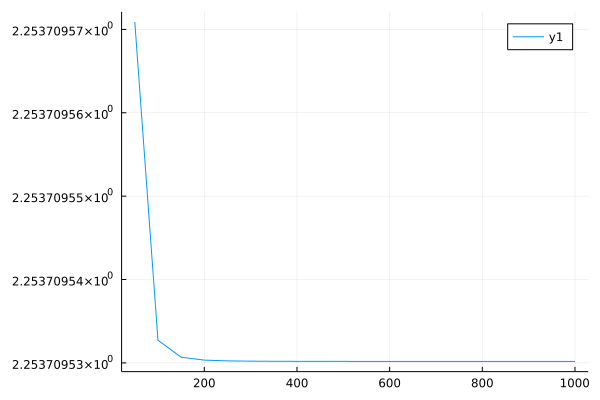

2.253709570890 (h: 0.0169974260)
2.253709532718 (h: 0.0084987130)
2.253709530675 (h: 0.0056658087)
2.253709530332 (h: 0.0042493565)
2.253709530238 (h: 0.0033994852)
2.253709530204 (h: 0.0028329043)
2.253709530190 (h: 0.0024282037)
2.253709530183 (h: 0.0021246782)
2.253709530179 (h: 0.0018886029)
2.253709530177 (h: 0.0016997426)
2.253709530175 (h: 0.0015452205)
2.253709530175 (h: 0.0014164522)
2.253709530174 (h: 0.0013074943)
2.253709530174 (h: 0.0012141019)
2.253709530173 (h: 0.0011331617)
2.253709530173 (h: 0.0010623391)
2.253709530173 (h: 0.0009998486)
2.253709530173 (h: 0.0009443014)
2.253709530173 (h: 0.0008946014)
2.253709530173 (h: 0.0008498713)
Area of the loop: 2.253709530172826


In [98]:
function integrate_simp(t, s, bc)

    function f(t, b)
        x, y = B(t, b)
        ft = dot([-y, x], dB(t, b))
        return ft
    end

    function simp(a, b, bc, h)
        fa = f(a, bc)
        fb = f(b, bc)
        fab = f((a+b)/2, bc)
        cI = (h/6) * (fa + 4*fab + fb)
        return cI
    end

    Is = []
    st = 50:50:1000

    for j in st
        I = 0
        steps = j
        a = t0
        h = (s0-t0)/steps
        b = a + h
        for i=1:steps
            cI = simp(a, b, bc, h)
            I += cI
            a = b
            b += h 
        end
        I /= 2
        append!(Is, I)
        @printf("%.12f (h: %.10f)\n", I, h)
    end
    p = plot(st, Is)
    @printf("Area of the loop: %.15f\n", last(Is))
    return [last(Is), p]
end

a, p = integrate_simp(t, s, bc)
display(p)

In [95]:
function animate_bezier(px, py, steps=100)
    n = length(px)-1
    # saving all in between de Casteljau points
    bs = [zeros(2,r) for r=n+1:-1:0]
    # base case Bézier points
    bs[1][1,:] = px 
    bs[1][2,:] = py
    points = zeros(steps,2)
    colors = [:green,:orange,:red,:yellow, :pink, :blue, :purple, :lightgreen] 
    if length(colors) < n
        return ErrorException("add more colors!")
    end
    c = 1
    anim = @animate for t in LinRange(0,1,steps)
        plot(axisratio=:equal, legend=false)
        plot!(px, py, linetype=:scatter)
        for i=1:n
            for j=0:n-i   
                # linear interpolation between twp ponts                   
                new_b = (1-t)*bs[i][:,j+1]+t*bs[i][:,j+2]
                bs[i+1][:,j+1] = new_b
                # drawing the line for linear interpolation as well as the specific point for t
                plot!(bs[i][1,j+1:j+2],bs[i][2,j+1:j+2], legend=false, color=colors[i])
                plot!([new_b[1]],[new_b[2]], linetype=:scatter, legend=false, color=colors[i])
                if i == n
                    points[c,:] = [new_b[1],new_b[2]]
                    # draw the curve until point t = LinRange(0,1,steps)[c]
                    plot!(points[1:c,1],points[1:c,2], color=:black)
                    c += 1
                end
            end
        end
    end
    gif(anim, "bezier_d2.gif", fps=30)
end

animate_bezier (generic function with 2 methods)

┌ Info: Saved animation to 
│   fn = /home/jk/Documents/faks/nm/num-mat/src/bezier_d2.gif
└ @ Plots /home/jk/.julia/packages/Plots/mnkn4/src/animation.jl:114


Plots.AnimatedGif("/home/jk/Documents/faks/nm/num-mat/src/bezier_d2.gif")
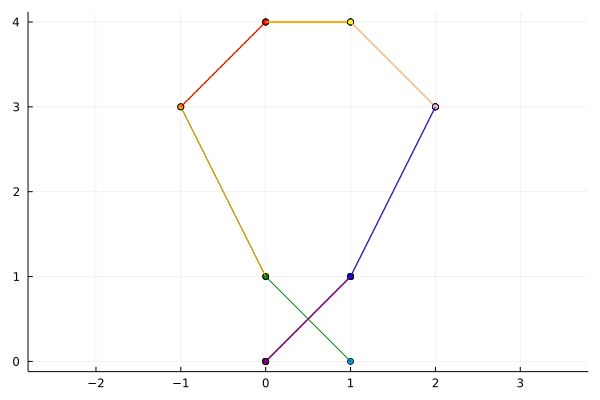

In [96]:
animate_bezier(pts[:,1], pts[:, 2])